In [1]:
import qinfer as qi
import matplotlib.pyplot as pl
import numpy as np

/Users/dsuess/Library/Miniconda3/envs/qinfer/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/Users/dsuess/Code/Qinfer/src/qinfer/parallel.py:52: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  "Could not import IPython parallel. "


In [2]:
class CircularModel(qi.Model):
    def __init__(self, sigma=.01, ):
        self._sigma = sigma
        super(CircularModel, self).__init__()
        
    @property
    def n_modelparams(self):
        return 1
    
    @property
    def expparams_dtype(self):
        return []
    
    @property
    def is_n_outcomes_constant(self):
        return True
    
    @property
    def n_outcomes(self):
        return 1
    
    def domain(self, _):
        return qi.RealDomain(min=0, max=2 * np.pi)
        
    def are_models_valid(self, modelparams):
        return (modelparams[..., 0] >= 0) * (modelparams[..., 0] < 2 * np.pi)
    
    def canonicalize(self, modelparams):
        return np.mod(modelparams, 2 * np.pi)
    
    def simulate_experiment(self, modelparams, expparams, repeat=1):
        x = modelparams[None, :,  None] + self._sigma * np.random.randn(repeat)
        return self.canonicalize(x)
    
    def likelihood(self, outcomes, modelparams, expparams):
        super(CircularModel, self).likelihood(outcomes, modelparams, expparams)
        nr_summands = np.ceil(self._sigma / np.pi) + 3
        n = np.arange(-nr_summands, nr_summands + 1)[:, None, None]
        x = outcomes[None, :, None] - modelparams[None, None, :, 0] + 2 * np.pi * n
        x /= self._sigma
        p = 1 / np.sqrt(2 * np.pi * self._sigma**2) * np.exp(- x * x / 2)
        return np.sum(p, axis=0)[..., None]

In [3]:
def weights_to_markersize(weights, maxsize=30):
    return maxsize * weights / np.max(weights)

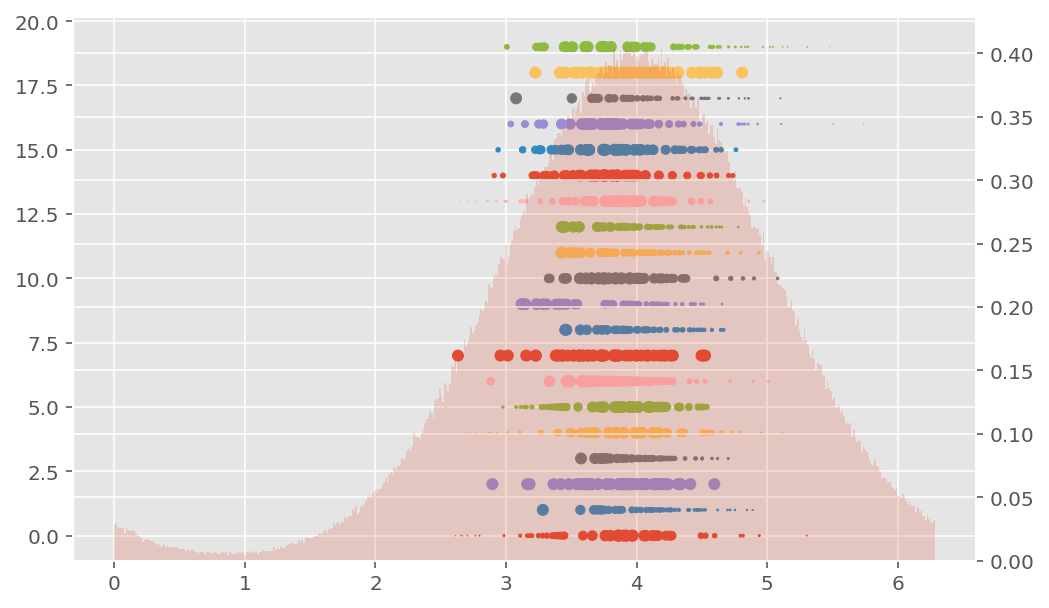

In [4]:
PARTICLES = 50
NR_OUTCOMES = 10

np.random.seed(1234)
modelparams_true = np.array([4])
model = CircularModel(sigma=1.)
outcomes = model.simulate_experiment(modelparams_true, [], repeat=NR_OUTCOMES).ravel()
resampler = qi.LiuWestResampler(a=0.0)

np.random.seed(5678)
for i in range(20):
    prior = qi.UniformDistribution(ranges=np.array([0, 2 * np.pi]))
    updater = qi.SMCUpdater(model, PARTICLES, prior, resampler=resampler)
    updater.batch_update(outcomes, np.empty((NR_OUTCOMES)), resample_interval=1)

    pl.scatter(updater.particle_locations, i * np.ones(PARTICLES),
               s=weights_to_markersize(updater.particle_weights))
    
pl.gca().twinx().hist(model.simulate_experiment(modelparams_true, [], repeat=1000000).ravel(),
                       bins=500, normed=True, alpha=.2);

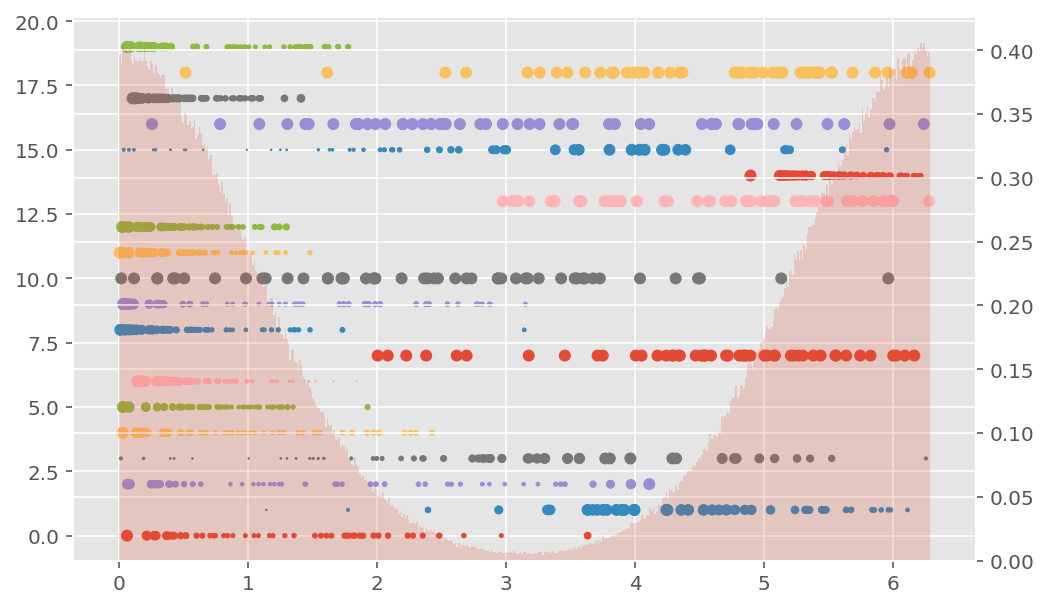

In [5]:
np.random.seed(1234)
modelparams_true = np.array([0.001])
model = CircularModel(sigma=1.)
outcomes = model.simulate_experiment(modelparams_true, [], repeat=NR_OUTCOMES).ravel()

np.random.seed(5678)
for i in range(20):
    prior = qi.UniformDistribution(ranges=np.array([0, 2 * np.pi]))
    updater = qi.SMCUpdater(model, PARTICLES, prior, resampler=resampler)
    updater.batch_update(outcomes, np.empty((NR_OUTCOMES)), resample_interval=1)

    pl.scatter(updater.particle_locations, i * np.ones(PARTICLES),
               s=weights_to_markersize(updater.particle_weights))
    
pl.gca().twinx().hist(model.simulate_experiment(modelparams_true, [], repeat=1000000).ravel(),
                       bins=500, normed=True, alpha=.2);

In [9]:
import qinfer.utils as u

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return rho, phi

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

class CircularDistribution(qi.ParticleDistribution):
    
    @classmethod
    def euclidean_mean(cls, weights, angles):
        x, y = pol2cart(1, angles)
        mean_x = super(CircularDistribution, cls).particle_mean(weights, x)
        mean_y = super(CircularDistribution, cls).particle_mean(weights, y)
        mean_amplitude, mean_angle = cart2pol(mean_x, mean_y)
        return mean_amplitude, np.mod(mean_angle, 2 * np.pi)
    
    @classmethod
    def particle_mean(cls, weights, locations):
        _, mean_angle = cls.euclidean_mean(weights, locations)
        return mean_angle
    
    @classmethod
    def particle_covariance_mtx(cls, weights, locations):
        mean_amplitude, _ = cls.euclidean_mean(weights, locations)
        return np.reshape(1 - mean_amplitude, (1, 1))

class CircularSMCUpdater(qi.SMCUpdater, CircularDistribution):
    pass

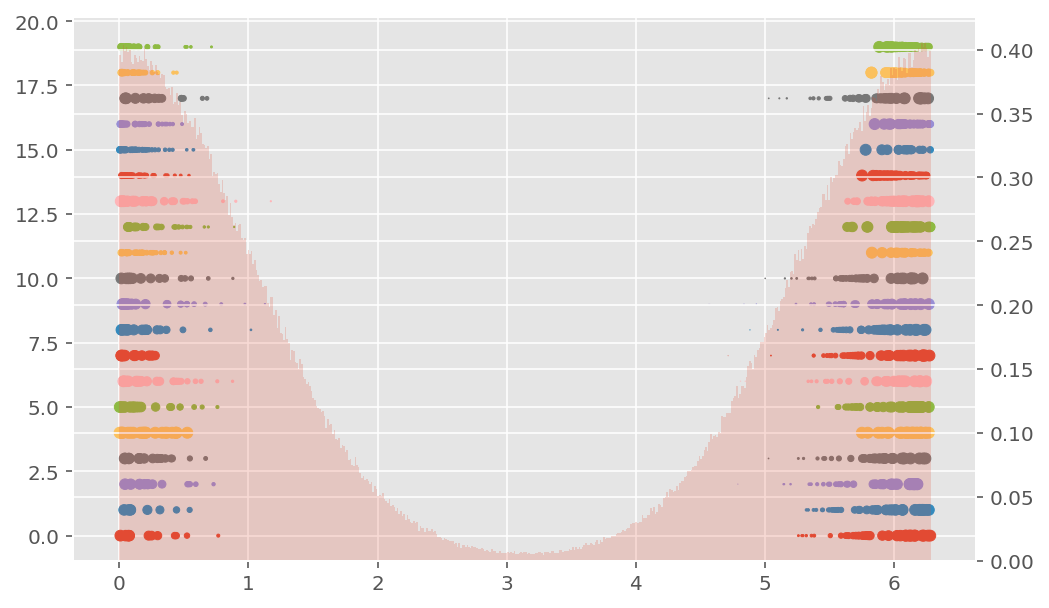

In [10]:
PARTICLES = 50
NR_OUTCOMES = 10

np.random.seed(1234)
modelparams_true = np.array([0.001])
model = CircularModel(sigma=1.)
outcomes = model.simulate_experiment(modelparams_true, [], repeat=NR_OUTCOMES).ravel()
# We need to disable postselection in the resampler since otherwise we loose the 
# new particle locations outside of [0, 2pi]
# This is a workaround for not using particle_mean in resamplers.py:322
resampler = qi.LiuWestResampler(a=0.0, postselect=False)

np.random.seed(5678)
for i in range(20):
    prior = qi.UniformDistribution(ranges=np.array([0, 2 * np.pi]))
    # We have to canonicalize since we disabled postselection
    updater = CircularSMCUpdater(model, PARTICLES, prior, resampler=resampler,
                                 canonicalize=True)
    updater.batch_update(outcomes, np.empty((NR_OUTCOMES)), resample_interval=1)

    pl.scatter(updater.particle_locations, i * np.ones(PARTICLES),
               s=weights_to_markersize(updater.particle_weights))
    
pl.gca().twinx().hist(model.simulate_experiment(modelparams_true, [], repeat=1000000).ravel(),
                       bins=500, normed=True, alpha=.2);